In [1]:
import os 
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pdb
from pyarrow import feather
from scipy.stats import sem

plt.rcParams.update({'font.size': 22})
plt.rcParams["figure.figsize"] = (10, 10)


In [2]:
#move up in directory
os.chdir('../')

from helpers import dot2_

In [3]:
os.getcwd()

'C:\\Users\\Bio_Psych\\Desktop\\Deniz\\tf-cpu\\p1_generalization'

In [4]:
# regret for human data

path_to_data = 'data/human_raw_data/'
data_file = 'data_chakroun_wiehler.csv'
human_df = pd.read_csv(open(path_to_data + data_file, 'rb'), index_col=0)


cum_reg_human = np.zeros([300,31])

# sub 
for sub in range(1,32):

    temp_df = human_df[human_df['vp'].values==sub]
    chosen_reward = [[p1,p2,p3,p4][ch-1] if ch != 0 else np.mean([p1,p2,p3,p4]) for ch, p1, p2, p3, p4 in zip(temp_df['choice'], temp_df['reward_b1'], temp_df['reward_b2'], temp_df['reward_b3'], temp_df['reward_b4'])]
    temp_df['reward'] = chosen_reward
    best_reward = np.array(np.max(temp_df[['reward_b1', 'reward_b2', 'reward_b3', 'reward_b4']], axis = 1))
    # calculate cumulative regret
    cum_reg_human[:,sub-1] = np.cumsum(best_reward - chosen_reward)



C:\Users\Bio_Psych\anaconda3\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [5]:
# regret for lstm data
def get_regret_rnn(file_path, n_trials = 300, n_walks = 3, n_ids = 20):

    cum_reg_lstm = np.zeros([n_trials,n_ids*n_walks])

    for id_ in range(n_ids):
        for walk in range(1,4):
            
            d = pickle.load(open(file_path.format(id_, walk), 'rb'))
            df = d.reset_index()
            chosen_reward = [[p1,p2,p3,p4][ch] for ch, p1, p2, p3, p4 in zip(df['choice'], df['p_rew_1'], df['p_rew_2'], df['p_rew_3'], df['p_rew_4'])]
            best_reward = np.array(np.max(df[['p_rew_1', 'p_rew_2', 'p_rew_3', 'p_rew_4']], axis = 1))
            # calculate cumulative regret (mult with 100 to compare to human data)
            cum_reg_lstm[:,(20*(walk-1))+id_] = np.cumsum(np.multiply(best_reward,100) - np.multiply(chosen_reward,100))
            
    return(cum_reg_lstm)

In [6]:
lstm_noisy = get_regret_rnn('data/rnn_raw_data/lstm2_a2c_nh_48_lr_0_0001_n_u_p_0_5_ew_0_vw_0_5_dr_0_5_res_d_f_p_0_1_rt_con_a_4_n_300_te_50000_id_{}_test_b_daw_p_{}')
se_lstm_noisy = sem(lstm_noisy, axis = 1)

lstm_noisy_ew_lin = get_regret_rnn('data/rnn_raw_data/lstm2_a2c_nh_48_lr_0_0001_n_u_p_0_5_ew_lin_vw_0_5_dr_0_5_res_d_f_p_0_1_rt_con_a_4_n_300_te_50000_id_{}_test_b_daw_p_{}')
se_lstm_noisy_ew_lin = sem(lstm_noisy_ew_lin, axis = 1)

lstm_ew_lin = get_regret_rnn('data/rnn_raw_data/lstm_a2c_nh_48_lr_0_0001_n_n_p_0_ew_lin_vw_0_5_dr_0_5_res_d_f_p_0_1_rt_con_a_4_n_300_te_50000_id_{}_test_b_daw_p_{}')
se_lstm_ew_lin = sem(lstm_ew_lin, axis = 1)

lstm_noisy_ew = get_regret_rnn('data/rnn_raw_data/lstm2_a2c_nh_48_lr_0_0001_n_u_p_0_5_ew_0_05_vw_0_5_dr_0_5_res_d_f_p_0_1_rt_con_a_4_n_300_te_50000_id_{}_test_b_daw_p_{}')
se_lstm_noisy_ew = sem(lstm_noisy_ew, axis = 1)

lstm_rei = get_regret_rnn('data/rnn_raw_data/lstm_rei_nh_48_lr_0_0001_n_n_p_0_ew_0_vw_0_5_dr_0_5_res_d_f_p_0_1_rt_con_a_4_n_300_te_50000_id_{}_test_b_daw_p_{}')
se_lstm_rei = sem(lstm_rei, axis = 1)



# standard error human
se_human = sem(cum_reg_human, axis = 1)

NameError: name 'mean_lstm_noisy_ew' is not defined

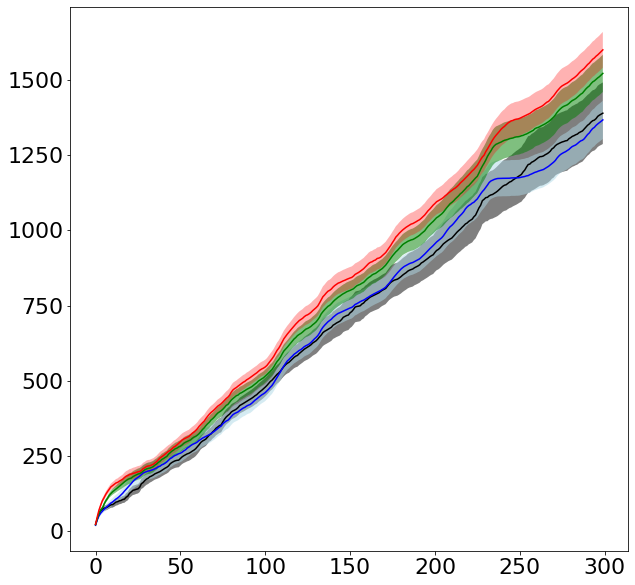

In [7]:
# plotting

mean_reg_human = np.mean(cum_reg_human, axis = 1)
mean_reg_lstm = np.mean(lstm_noisy, axis = 1)

mean_lstm_noisy_ew_lin = np.mean(lstm_noisy_ew_lin, axis = 1)
mean_lstm_ew_lin = np.mean(lstm_ew_lin, axis = 1)

mean_lstm_rei = np.mean(lstm_rei, axis = 1)



plt.plot(mean_reg_human, label = 'Human', c = 'black')
plt.fill_between(range(len(mean_reg_human)), mean_reg_human - se_human, mean_reg_human + se_human, facecolor='black', alpha=0.5)
plt.plot(mean_reg_lstm, label = 'Noisy LSTM', c = 'blue')
plt.fill_between(range(len(mean_reg_human)), mean_reg_lstm - se_lstm_noisy, mean_reg_lstm + se_lstm_noisy, facecolor='lightblue', alpha=0.5)

plt.plot(mean_lstm_noisy_ew_lin, label = 'Noisy LSTM linear entropy', color = 'green')
plt.fill_between(range(len(mean_reg_human)), mean_lstm_noisy_ew_lin - se_lstm_noisy_ew_lin, mean_lstm_noisy_ew_lin + se_lstm_noisy_ew_lin, facecolor='green', alpha=0.5)

plt.plot(mean_lstm_ew_lin, label = 'LSTM linear entropy', color = 'red')
plt.fill_between(range(len(mean_reg_human)), mean_lstm_ew_lin - se_lstm_ew_lin, mean_lstm_ew_lin  + se_lstm_ew_lin, facecolor='red', alpha=0.3)

plt.plot(mean_lstm_noisy_ew, label = 'Noisy LSTM entropy', color = 'red')
plt.fill_between(range(len(mean_reg_human)), mean_lstm_noisy_ew - se_lstm_noisy_ew, mean_lstm_noisy_ew  + se_lstm_noisy_ew, facecolor='red', alpha=0.3)

plt.plot(mean_lstm_rei, label = 'LSTM rei', color = 'red')
plt.fill_between(range(len(mean_reg_human)), mean_lstm_rei - se_lstm_rei, mean_lstm_rei  + se_lstm_rei, facecolor='red', alpha=0.3)


plt.ylabel('Cumulative regret')
plt.xlabel('Trials')
plt.legend(frameon=False)

# Cumulative Regret for each walk

In [93]:
# lstms
def get_regret_for_walk_rnn(file_path, n_trials = 300, walk = 3, n_ids = 20):

    cum_reg_lstm = np.zeros([n_trials,n_ids])

    for id_ in range(n_ids):
            
            d = pickle.load(open(file_path.format(id_, walk), 'rb'))
            df = d.reset_index()
            
#             print(df[['p_rew_1', 'p_rew_2', 'p_rew_3', 'p_rew_4']])
            
            chosen_reward = [[p1,p2,p3,p4][ch] for ch, p1, p2, p3, p4 in zip(df['choice'], df['p_rew_1'], df['p_rew_2'], df['p_rew_3'], df['p_rew_4'])]
            best_reward = np.array(np.max(df[['p_rew_1', 'p_rew_2', 'p_rew_3', 'p_rew_4']], axis = 1))
            # calculate cumulative regret (mult with 100 to compare to human data)
            cum_reg_lstm[:,id_] = np.cumsum(np.multiply(best_reward,100) - np.multiply(chosen_reward,100))
            
    return(cum_reg_lstm)

lstm_noisy_w1 = get_regret_for_walk_rnn('data/rnn_raw_data/lstm2_a2c_nh_48_lr_0_0001_n_u_p_0_5_ew_0_vw_0_5_dr_0_5_res_d_f_p_0_1_rt_con_a_4_n_300_te_50000_id_{}_test_b_daw_p_{}', walk = 1)
lstm_noisy_w2 = get_regret_for_walk_rnn('data/rnn_raw_data/lstm2_a2c_nh_48_lr_0_0001_n_u_p_0_5_ew_0_vw_0_5_dr_0_5_res_d_f_p_0_1_rt_con_a_4_n_300_te_50000_id_{}_test_b_daw_p_{}', walk = 2)
lstm_noisy_w3 = get_regret_for_walk_rnn('data/rnn_raw_data/lstm2_a2c_nh_48_lr_0_0001_n_u_p_0_5_ew_0_vw_0_5_dr_0_5_res_d_f_p_0_1_rt_con_a_4_n_300_te_50000_id_{}_test_b_daw_p_{}', walk = 3)

lstm_noisy_ew_lin_w1 = get_regret_for_walk_rnn('data/rnn_raw_data/lstm2_a2c_nh_48_lr_0_0001_n_u_p_0_5_ew_lin_vw_0_5_dr_0_5_res_d_f_p_0_1_rt_con_a_4_n_300_te_50000_id_{}_test_b_daw_p_{}', walk = 1)
lstm_noisy_ew_lin_w2 = get_regret_for_walk_rnn('data/rnn_raw_data/lstm2_a2c_nh_48_lr_0_0001_n_u_p_0_5_ew_lin_vw_0_5_dr_0_5_res_d_f_p_0_1_rt_con_a_4_n_300_te_50000_id_{}_test_b_daw_p_{}', walk = 2)
lstm_noisy_ew_lin_w3 = get_regret_for_walk_rnn('data/rnn_raw_data/lstm2_a2c_nh_48_lr_0_0001_n_u_p_0_5_ew_lin_vw_0_5_dr_0_5_res_d_f_p_0_1_rt_con_a_4_n_300_te_50000_id_{}_test_b_daw_p_{}', walk = 3)

lstm_ew_lin_w1 = get_regret_for_walk_rnn('data/rnn_raw_data/lstm_a2c_nh_48_lr_0_0001_n_n_p_0_ew_lin_vw_0_5_dr_0_5_res_d_f_p_0_1_rt_con_a_4_n_300_te_50000_id_{}_test_b_daw_p_{}', walk = 1)
lstm_ew_lin_w2 = get_regret_for_walk_rnn('data/rnn_raw_data/lstm_a2c_nh_48_lr_0_0001_n_n_p_0_ew_lin_vw_0_5_dr_0_5_res_d_f_p_0_1_rt_con_a_4_n_300_te_50000_id_{}_test_b_daw_p_{}', walk = 2)
lstm_ew_lin_w3 = get_regret_for_walk_rnn('data/rnn_raw_data/lstm_a2c_nh_48_lr_0_0001_n_n_p_0_ew_lin_vw_0_5_dr_0_5_res_d_f_p_0_1_rt_con_a_4_n_300_te_50000_id_{}_test_b_daw_p_{}', walk = 3)



In [94]:
# human 
path_to_data = 'data/human_raw_data/'
data_file = 'data_chakroun_wiehler.csv'
human_df = pd.read_csv(open(path_to_data + data_file, 'rb'), index_col=0)


cum_reg_human_w1 = np.zeros([300,1])
cum_reg_human_w1[:,0] = [np.nan]*300

cum_reg_human_w2 = np.zeros([300,1])
cum_reg_human_w2[:,0] = [np.nan]*300

cum_reg_human_w3 = np.zeros([300,1])
cum_reg_human_w3[:,0] = [np.nan]*300

 
for sub in range(1,32):

    temp_df = human_df[human_df['vp'].values==sub]
    chosen_reward = [[p1,p2,p3,p4][ch-1] if ch != 0 else np.mean([p1,p2,p3,p4]) for ch, p1, p2, p3, p4 in zip(temp_df['choice'], temp_df['reward_b1'], temp_df['reward_b2'], temp_df['reward_b3'], temp_df['reward_b4'])]
    temp_df['reward'] = chosen_reward#np.divide(chosen_reward, 100)
    best_reward = np.array(np.max(temp_df[['reward_b1', 'reward_b2', 'reward_b3', 'reward_b4']], axis = 1))

    # calculate cumulative regret
    if sum(43.8609581463353 == temp_df[['reward_b1', 'reward_b2', 'reward_b3', 'reward_b4']].iloc[0,:].values):
        
        cum_reg_human_w1 = np.hstack((cum_reg_human_w1,np.cumsum(best_reward - chosen_reward).reshape(-1,1)))
        
        # get reversal
        best_arm = np.argmax(temp_df[['reward_b1', 'reward_b2', 'reward_b3', 'reward_b4']].values, axis = 1)
#         is_reversal_w1 = [int(best_arm[t] != best_arm[t-1]) for t in range(1, len(best_arm))]

        

    if sum(50.0674374012484 == temp_df[['reward_b1', 'reward_b2', 'reward_b3', 'reward_b4']].iloc[0,:].values):
        
        cum_reg_human_w2 = np.hstack((cum_reg_human_w2,np.cumsum(best_reward - chosen_reward).reshape(-1,1)))
        
        # get reversal
        best_arm = np.argmax(temp_df[['reward_b1', 'reward_b2', 'reward_b3', 'reward_b4']].values, axis = 1)
#         is_reversal_w2 = [int(best_arm[t] != best_arm[t-1]) for t in range(1, len(best_arm))]
        
    if sum(38.184263964316294 == temp_df[['reward_b1', 'reward_b2', 'reward_b3', 'reward_b4']].iloc[0,:].values):

        cum_reg_human_w3 = np.hstack((cum_reg_human_w3,np.cumsum(best_reward - chosen_reward).reshape(-1,1)))
        
        # get reversal
        best_arm = np.argmax(temp_df[['reward_b1', 'reward_b2', 'reward_b3', 'reward_b4']].values, axis = 1)
#         is_reversal_w3 = [int(best_arm[t] != best_arm[t-1]) for t in range(1, len(best_arm))]

C:\Users\Bio_Psych\anaconda3\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [109]:
# standard errors
se_human_w1 = sem(cum_reg_human_w1, axis = 1, nan_policy='omit')
se_human_w2 = sem(cum_reg_human_w2, axis = 1, nan_policy='omit')
se_human_w3 = sem(cum_reg_human_w3, axis = 1, nan_policy='omit')

se_lstm_noisy_w1 = sem(lstm_noisy_w1, axis = 1, nan_policy='omit')
se_lstm_noisy_w2 = sem(lstm_noisy_w2, axis = 1, nan_policy='omit')
se_lstm_noisy_w3 = sem(lstm_noisy_w3, axis = 1, nan_policy='omit')

se_lstm_noisy_ew_lin_w1 = sem(lstm_noisy_ew_lin_w1, axis = 1, nan_policy='omit')
se_lstm_noisy_ew_lin_w2 = sem(lstm_noisy_ew_lin_w2, axis = 1, nan_policy='omit')
se_lstm_noisy_ew_lin_w3 = sem(lstm_noisy_ew_lin_w3, axis = 1, nan_policy='omit')


se_lstm_ew_lin_w1 = sem(lstm_ew_lin_w1, axis = 1, nan_policy='omit')
se_lstm_ew_lin_w2 = sem(lstm_ew_lin_w2, axis = 1, nan_policy='omit')
se_lstm_ew_lin_w3 = sem(lstm_ew_lin_w3, axis = 1, nan_policy='omit')







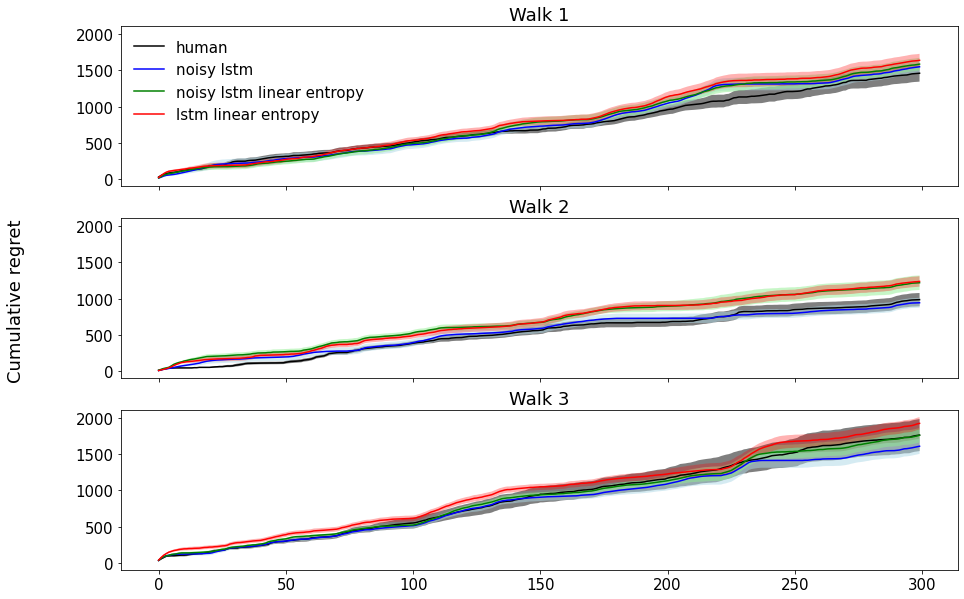

In [130]:
fig, ax = plt.subplots(3,1, figsize=(15, 10), sharex='all', sharey='all')

plt.rcParams.update({'font.size': 15})

fig.supylabel('Cumulative regret')

human_mean_w1 = np.nanmean(cum_reg_human_w1, axis = 1)
human_mean_w2 = np.nanmean(cum_reg_human_w2, axis = 1)
human_mean_w3 = np.nanmean(cum_reg_human_w3, axis = 1)

lstm_noisy_mean_w1 = np.nanmean(lstm_noisy_w1, axis = 1)
lstm_noisy_mean_w2 = np.nanmean(lstm_noisy_w2, axis = 1)
lstm_noisy_mean_w3 = np.nanmean(lstm_noisy_w3, axis = 1)

lstm_noisy_ew_lin_mean_w1 = np.nanmean(lstm_noisy_ew_lin_w1, axis = 1)
lstm_noisy_ew_lin_mean_w2 = np.nanmean(lstm_noisy_ew_lin_w2, axis = 1)
lstm_noisy_ew_lin_mean_w3 = np.nanmean(lstm_noisy_ew_lin_w3, axis = 1)

lstm_ew_lin_mean_w1 = np.nanmean(lstm_ew_lin_w1, axis = 1)
lstm_ew_lin_mean_w2 = np.nanmean(lstm_ew_lin_w2, axis = 1)
lstm_ew_lin_mean_w3 = np.nanmean(lstm_ew_lin_w3, axis = 1)


ax[0].set_title('Walk 1')
ax[0].plot(human_mean_w1, label = 'human', c = 'black')
ax[0].fill_between(range(len(human_mean_w1)), human_mean_w1 - se_human_w1, human_mean_w1 + se_human_w1, facecolor='black', alpha=0.5)

ax[0].plot(lstm_noisy_mean_w1, label = 'noisy lstm', color = 'blue')
ax[0].fill_between(range(len(lstm_noisy_mean_w1)), lstm_noisy_mean_w1 - se_lstm_noisy_w1, lstm_noisy_mean_w1 + se_lstm_noisy_w1, facecolor='lightblue', alpha=0.5)

ax[0].plot(lstm_noisy_ew_lin_mean_w1, label = 'noisy lstm linear entropy', color = 'green')
ax[0].fill_between(range(len(lstm_noisy_ew_lin_mean_w1)), lstm_noisy_ew_lin_mean_w1 - se_lstm_noisy_ew_lin_w1, lstm_noisy_ew_lin_mean_w1 + se_lstm_noisy_ew_lin_w1, facecolor='lightgreen', alpha=0.5)

ax[0].plot(lstm_ew_lin_mean_w1, label = 'lstm linear entropy', color = 'red')
ax[0].fill_between(range(len(lstm_ew_lin_mean_w1)), lstm_ew_lin_mean_w1 - se_lstm_ew_lin_w1, lstm_ew_lin_mean_w1 + se_lstm_ew_lin_w1, facecolor='red', alpha=0.3)


# x_vals_reversals_w1 = np.linspace(0,300,300, endpoint=False)[np.append(False,np.array(is_reversal_w1)>0)]
# ax[0].vlines(x_vals_reversals_w1, ymin = 0, ymax = 2000, linestyle = 'dashed', color = 'grey')

ax[0].legend(frameon = False)

ax[1].set_title('Walk 2')
ax[1].plot(human_mean_w2, label = 'human', c = 'black')
ax[1].fill_between(range(len(human_mean_w2)), human_mean_w2 - se_human_w2, human_mean_w2 + se_human_w2, facecolor='black', alpha=0.5)

ax[1].plot(lstm_noisy_mean_w2, label = 'noisy lstm', color = 'blue')
ax[1].fill_between(range(len(lstm_noisy_mean_w2)), lstm_noisy_mean_w2 - se_lstm_noisy_w2, lstm_noisy_mean_w2 + se_lstm_noisy_w2, facecolor='lightblue', alpha=0.5)

ax[1].plot(lstm_noisy_ew_lin_mean_w2, label = 'noisy lstm linear entropy', color = 'green')
ax[1].fill_between(range(len(lstm_noisy_ew_lin_mean_w2)), lstm_noisy_ew_lin_mean_w2 - se_lstm_noisy_ew_lin_w2, lstm_noisy_ew_lin_mean_w2 + se_lstm_noisy_ew_lin_w2, facecolor='lightgreen', alpha=0.5)

ax[1].plot(lstm_ew_lin_mean_w2, label = 'lstm linear entropy', color = 'red')
ax[1].fill_between(range(len(lstm_ew_lin_mean_w2)), lstm_ew_lin_mean_w2 - se_lstm_ew_lin_w2, lstm_ew_lin_mean_w2 + se_lstm_ew_lin_w2, facecolor='red', alpha=0.3)


# x_vals_reversals_w2 = np.linspace(0,300,300, endpoint=False)[np.append(False,np.array(is_reversal_w2)>0)]
# ax[1].vlines(x_vals_reversals_w2, ymin = 0, ymax = 2000, linestyle = 'dashed', color = 'grey')


ax[2].set_title('Walk 3')

ax[2].plot(human_mean_w3, label = 'human', c = 'black')
ax[2].fill_between(range(len(human_mean_w3)), human_mean_w3 - se_human_w3, human_mean_w3 + se_human_w3, facecolor='black', alpha=0.5)

ax[2].plot(lstm_noisy_mean_w3, label = 'noisy lstm', color = 'blue')
ax[2].fill_between(range(len(lstm_noisy_mean_w3)), lstm_noisy_mean_w3 - se_lstm_noisy_w3, lstm_noisy_mean_w3 + se_lstm_noisy_w3, facecolor='lightblue', alpha=0.5)

ax[2].plot(lstm_noisy_ew_lin_mean_w3, label = 'noisy lstm linear entropy', color = 'green')
ax[2].fill_between(range(len(lstm_noisy_ew_lin_mean_w3)), lstm_noisy_ew_lin_mean_w3 - se_lstm_noisy_ew_lin_w3, lstm_noisy_ew_lin_mean_w3 + se_lstm_noisy_ew_lin_w3, facecolor='lightgreen', alpha=0.5)

ax[2].plot(lstm_ew_lin_mean_w3, label = 'lstm linear entropy', color = 'red')
ax[2].fill_between(range(len(lstm_ew_lin_mean_w3)), lstm_ew_lin_mean_w3 - se_lstm_ew_lin_w3, lstm_ew_lin_mean_w3 + se_lstm_ew_lin_w3, facecolor='red', alpha=0.3)

#plt.savefig('cumulative_regret_per_walk.png')